# Notebook mainly for creating the dictionary of stops and travel times/distances for look up

In [1]:
import os
import pandas as pd
import pickle

## To create the dictionary from the `pair_tt_dd.py` file

In [54]:
df = pd.read_pickle('results/pair_tt_dd_stops.pkl')
df = df.drop_duplicates(subset=['current_node', 'next_node'])
df['key_pair'] = list(zip(df.current_node, df.next_node))
df = df.set_index('key_pair')
stops_tt_dd_dict = df.drop(['current_node', 'next_node', 'current_stop', 'next_stop'], axis=1).to_dict('index')
with open('results/stops_tt_dd_node_dict.pkl', 'wb') as handle:
    pickle.dump(stops_tt_dd_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Creating the stops to node dictionary

In [62]:
fp = '/home/jptalusan/mta_simulator/code/data/stops_node_matching.pkl'
stop_nodes = pd.read_pickle(fp)
stop_nodes = stop_nodes.set_index('stop_id_original')
stop_nodes_dict = stop_nodes.drop(['stop_sequence', 
                                   'stop_name', 'map_latitude', 
                                   'map_longitude', 
                                   'nearest_edge'], axis=1).to_dict('index')
with open('results/stops_node_matching_dict.pkl', 'wb') as handle:
    pickle.dump(stop_nodes_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
# Usage
with open('results/stops_tt_dd_node_dict.pkl', 'rb') as handle:
    stops_tt_dd_dict = pickle.load(handle)
with open('results/stops_node_matching_dict.pkl', 'rb') as handle:
    stop_nodes_dict = pickle.load(handle)

nn_id = 'DWMRT'
cn_id = 'DWMRTX'
nn = stop_nodes_dict[nn_id]['nearest_node']
cn = stop_nodes_dict[cn_id]['nearest_node']
print(cn, nn)

tt = stops_tt_dd_dict[(cn, nn)]['travel_time_s']
if tt < 0:
    tt = stops_tt_dd_dict[(nn, cn)]['travel_time_s']
    dd = stops_tt_dd_dict[(nn, cn)]['distance_m']
else:
    dd = stops_tt_dd_dict[(cn, nn)]['distance_m']
print(tt, dd)

8231407036 7668988489
63.6 960.0269999999999


# Might not be needed anymore vvvvv

## To solve the issue of some missing stops in the dictionary
* Probably due to not being able to find the exact location of the stop in OSM.
* Then it got removed by a drop_duplicate somewhere

In [2]:
df = pd.read_pickle('results/pair_tt_dd_stops.pkl')
fp = '/home/jptalusan/mta_simulator/code/data/stops_node_matching.pkl'
stop_nodes = pd.read_pickle(fp)
stop_nodes.query("stop_id_original == 'MUREXPWN'")

# Merging alternative names to prevent failing to find stops.
df = pd.merge(stop_nodes[['stop_id_original', 'nearest_node']], df, right_on='current_node', left_on='nearest_node')
df = df.drop_duplicates()
df = df.drop_duplicates(subset=['stop_id_original','nearest_node','current_node','next_node','travel_time_s','distance_m','current_stop'])
df = df[['stop_id_original', 'current_stop']].drop_duplicates().query("stop_id_original != current_stop").drop_duplicates(subset=['stop_id_original'])
df = df.set_index('stop_id_original')
matching_stop_names_dict = df.to_dict('index')
with open('results/matching_stop_names_dict.pkl', 'wb') as handle:
    pickle.dump(matching_stop_names_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

,stop_sequence,stop_id_original,stop_name,map_latitude,map_longitude,nearest_node,nearest_edge
481,30,MUREXPWN,MURFREESBORO PIKE & EXPRESSWAY PARK,36.145896,-86.753302,202255344,"(202255344, 202302733, 0)"


## DBSCAN Clustering

[[  -1   75]
 [   0 1786]
 [   1   52]
 [   2   18]
 [   3  122]
 [   4   13]
 [   5   16]
 [   6    8]
 [   7   10]]
[[ -1 579]
 [  0 655]
 [  1  83]
 [  2  69]
 [  3  23]
 [  4 102]
 [  5  22]
 [  6  22]
 [  7  49]
 [  8  12]
 [  9  14]
 [ 10  13]
 [ 11  21]
 [ 12  24]
 [ 13  10]
 [ 14  13]
 [ 15  16]
 [ 16  18]
 [ 17  10]
 [ 18  10]
 [ 19  21]]
21


/home/jptalusan/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

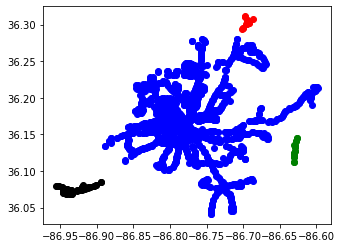

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

import pandas as pd
fp = 'results/stops_node_matching.pkl'
df = pd.read_pickle(fp)
df

db = DBSCAN(eps=0.00019, min_samples=10, metric='haversine')
res = db.fit(np.radians(df[['map_latitude', 'map_longitude']]))
labels = res.labels_
num_clusters = len(set(labels))

unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)
df['label'] = labels

import geopandas as gpd
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.map_longitude, df.map_latitude))
# gdf.query("label == 0").plot(color='red')
df = gdf.query("label == 0")

db = DBSCAN(eps=0.00008, min_samples=10, metric='haversine')
res = db.fit(np.radians(df[['map_latitude', 'map_longitude']]))
labels = res.labels_
num_clusters = len(set(labels))

unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)
df['label'] = labels
print(num_clusters)
ax = gdf.query("label == 4").plot(color='red')
gdf.query("label == 0").plot(color='blue', ax=ax)
gdf.query("label == 2").plot(color='green', ax=ax)
gdf.query("label == 1").plot(color='black', ax=ax)

### Break Davidson into grids

5
5


<AxesSubplot:>

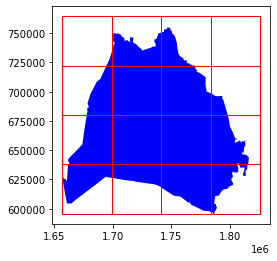

In [ ]:
from shapely.geometry import Polygon

fp = os.path.join('data', 'shapefiles', "tncounty")
gdf_county = gpd.read_file(fp)
gdf_dav = gdf_county[gdf_county["NAME"] == "Davidson"]
gdf_david = gdf_dav.to_crs("EPSG:4326")
gdf_david.crs
xmin, ymin, xmax, ymax = gdf_dav.total_bounds
gdf_dav.total_bounds
length = 5280 * 8
wide = 5280 * 8

cols = list(np.arange(xmin, xmax + wide, wide))
print(len(cols))
rows = list(np.arange(ymin, ymax + length, length))
print(len(cols))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons})
fp = os.path.join('data', 'shapefiles', 'grid_shapes.shp')
grid.to_file(fp)
grid.plot(ax = gdf_dav.plot(color='blue'), color='none', edgecolor='red')